# Модель микроуровневого стресс-тестирования (на уровне отдельных компаний-застройщиков) - "Банкротства застройщиков"

In [362]:
%matplotlib inline

from os import path, getcwd
from IPython.display import Markdown as md
import pandas as pd
import numpy as np
import sqlalchemy as sa
import statsmodels.api as sm
import matplotlib.pyplot as plt

# общие константы и функции
idx=pd.IndexSlice # объект для индексации мультииндексного фрейма
strDB_path=path.join('DB', 'bankrp.sqlite3')

# константы базы данных SQLite3
strNOZA_table='noza' # название таблицы NOZA в базе данных SQLite
strNOZA_agg='noza_ag' # название рабочего  представления для таблицы NOZA в базе данных SQLite (агрегация исходных показателей по инн и году запуска проекта)
strNOZA_data_pass='noza_columns' # таблица с названиями колонок для таблицы noza
strSPARK_table='spark' # название таблицы SPARK в базе данных SQLite
strSPARK_agg='spark_ag' # название рабочего  представления для таблицы SPARK в базе данных SQLite (ROA из базы)
strSPARK_agg_roa_calc='spark_ag_roa_calc' # название рабочего  представления для таблицы SPARK (ROA считаем)
strSPARK_data_pass='spark_columns' # таблица с названиями колонок для таблицы SPARK
strLOAN_table='loan' # название таблицы LOAN в базе данных SQLite
strLOAN_data_pass='loan_columns' # таблица с названиями колонок для таблицы loan
strLOAN_agg='loan_agg' # название рабочего  представления для таблицы LOAN в базе данных SQLite (агрегация исходных показателей по инн и году запуска проекта)

# ------------

# пути и константы для данных из Excel-версии модели и базы данных
strModelSource=path.join('.', 'DB', 'SRC', 'Долгосрочная модель.xlsx')
strMargaSheet='Новостройки'
strModelSheet='Модель'
#---------------

strMD='''
<div class="alert alert-block alert-success">
<b>База данных - {bd_path}<br>
<a href="{bankrupt_prob_DB}?DATABASE={bd_path}" target="_blank">Работа с базой данных для этой модели</a></b><br>
</div>
'''.format(bankrupt_prob_DB='bankrupt_prob_DB.ipynb', bd_path=strDB_path)
md(strMD)


<div class="alert alert-block alert-success">
<b>База данных - DB/bankrp.sqlite3<br>
<a href="bankrupt_prob_DB.ipynb?DATABASE=DB/bankrp.sqlite3" target="_blank">Работа с базой данных для этой модели</a></b><br>
</div>


## Подготовка данных

 
  1. **Чтение данных из базы данных (таблицы SPARK, NOZA и LOAN).** Данные читаются посредством запросов, созданных на этапе созднания базы данных. Первичный счет показателей осуществляется в этих запросах. При желании можно загрузить данные непосредственно из таблиц, для этого надо поменять название таблицы в строке запроса, в коде, в данном блокноте. Однако вычисления на стороне базы данных несколько быстрее, чем вычисления в коде.   
  2. **Чтение данных из "Долгосрочной модели".** Эти данные предполагается в будущем моделировать в Питоне, однако в настоящий момент они беруться из модели в файле Excel. Эти данные необходимы для построения и расчета промежуточных под-моделей, используемых в основном блоке расчета модели банкротств  
  3. **Построение и расчет промежуточных под-моделей**. Под-модели используются в качестве поставщиков данных для основной модели

### Чтение данных из базы

Даные из таблицы NOZA читаются запросом noza_agg. В запросе данные группируются по ИНН застройщика, по году сдачи проекта, суммируются цены проектов и вводимая жилая площадь построек (т.е. считается суммарная стоимость всех проектов и вся вводимая жилая площадь каждого застройщика в год).  


Данные из таблицы SPARK читаются запросом spark_ag. В запросе расчитывается показатель Z_A: 
`модуль((Кредиторская задолженность - Дебиторская задолженность) / Активы всего)`.

Показатель ROA берется из базы данных, одноко он так же может расчитываться по формуле `Чистая прибыль/Активы всего` (для этого надо использовать запрос spark_ag_roa_calc)


Данные из таблицы LOAN читаются запросом loan_agg. Расчеты выполняются в блокноте

In [363]:
strSELECT_NOZA='select * from {noza_table}'.format(noza_table=strNOZA_agg)
strSELECT_spark='select * from {spark_table}'.format(spark_table=strSPARK_agg)
strSELECT_LOAN='select * from {loan_table}'.format(loan_table=strLOAN_agg)

conWork = sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=strDB_path)) # connection к рабочей базе данных


из таблицы NOZA берем только последнюю точку по дате публикации

In [364]:
pdfNoza=pd.read_sql(strSELECT_NOZA, con=conWork)
pdfNoza['pub_date']=pd.to_datetime(pdfNoza['pub_date'], format='%Y-%m-%d')
pdfNoza.sort_values(by='pub_date', ascending=False)
pdfNoza=pdfNoza.loc[pdfNoza['pub_date']==pdfNoza['pub_date'].max(), (c for c in pdfNoza.columns if c !='pub_date')] # берем последнюю по дате публикации точку - теоретически возможно хранить в БД несколько временных точек
print(pdfNoza.shape)
pdfNoza.head()

(4616, 4)


,inn,completion_year,price,square
0,0105003792,2020,367349984,9327.82
1,0105008695,2020,284736960,6943.00
2,0106003795,2020,249000000,9639.37
3,0107008891,2020,98972928,4680.96
4,0107022575,2020,582293936,18055.21


In [365]:
pdfSPARK=pd.read_sql(strSELECT_spark, con=conWork)
pdfSPARK.replace({None:np.nan}, inplace=True)
print(pdfSPARK.shape)
pdfSPARK.head()

(103968, 6)


,inn,year,capital,Cancel_date,ROA,Z_A
0,3906245291,2018,10000000.0,NaN,-0.0103,0.155739
1,3801132195,2018,10000000.0,NaN,-0.0208,0.050148
2,5050102110,2018,20000.0,NaN,0.0003,0.357920
3,7448046410,2018,150010000.0,NaN,0.0548,0.103509
4,1840032987,2018,5050000.0,NaN,-0.0189,0.041587


в таблице loan считаем среднюю ставку за год 

In [366]:
pdfLOAN=pd.read_sql(strSELECT_LOAN, con=conWork)

pdfLOAN['date']=pd.to_datetime(pdfLOAN['date'], format='%Y-%m-%d')
pdfLOAN.set_index('date').groupby(by=pd.Grouper(freq='Y'))['loan_nonfin'].mean()

date
2014-12-31    11.135000
2015-12-31    15.716667
2016-12-31    12.592500
2017-12-31    10.560000
2018-12-31     8.866667
2019-12-31     8.753333
2020-12-31     7.554000
Freq: A-DEC, Name: loan_nonfin, dtype: float64

## Загрузка данных из долгосрочной модели

<div class="alert alert-block alert-info">
    В данном блокноте источник - excel-файл с долгосрочной моделью - располагается локально, в каталоге ./DB/SRC<br>
    Чтобы использовать последнюю версию модели сохранить  файл с моделью с расширением xlsx и загрузить его по этому пути
</div>

Эти данные используются для расчета под-моделей: моделирования средней по отрасли рентабельности застройщиков и ...

Читаем:  
   - Изменение среднесписочной численности работников (лист Модель, строка 493)
   - Индекс физобъема выпуска (лист Модель, строка 489)
   - Маржа прибыли застройщиков (лист Новостройки, строка 10)
   - Индексы номинальных цен на рынке жилья, на вторичном рынке (лист Модель, строка 687, делить на 100)

In [367]:
pdfXLS_model=pd.read_excel(strModelSource, sheet_name=strModelSheet, usecols='B, G:AZ', 
                           skiprows=[i for i in range(1500) if i not in [2, 686, 492, 488]], index_col=0)
pdfXLS_model=pdfXLS_model.T
print('Прочитано из файла ексель', pdfXLS_model.shape)
# print(pdfXLS_model.head())
print('Читаем маржу из листа Новостройки, добавляем во фрейм', end='...')
pdfXLS_model['marga']=pd.read_excel(strModelSource, sheet_name=strMargaSheet, usecols='B, K:AZ',
                      skiprows=[i for i in range(255) if i not in [0, 9, 10]], 
                      index_col=0).loc['маржа прибыли застройщиков'] / 100
print('сделано - ', pdfXLS_model.shape)
print('Переименовывыние колонок для удоства использования', end='...')
pdfXLS_model.columns=['I_phyvol_issue', 'Chng_avrg_num_empls', 'I_nom_prices_sec_market', 'marga']
print('сделано')
pdfXLS_model.head()

Прочитано из файла ексель (28, 3)
Читаем маржу из листа Новостройки, добавляем во фрейм...сделано -  (28, 4)
Переименовывыние колонок для удоства использования...сделано


,I_phyvol_issue,Chng_avrg_num_empls,I_nom_prices_sec_market,marga
2009,NaN,NaN,0.9455,1.434751
2010,1.050,0.960931,0.9843,1.343579
2011,1.051,1.007171,1.0827,1.137379
2012,1.025,1.016925,1.1524,1.210883
2013,1.001,0.987682,1.0782,1.210797


## Построение и расчет промежуточных моделей

### Подготовка данных для моделирования

    X - предикторы фактических значений
    x - предикторы прогнозных значений
    Y - известные объясняемые значения
    y - прогнозные объясняемые значения
    
К `X` и `x` добавляется **интерсептор**. Переменная `lag` задает сдвиг (положительное значение - вправо, отрицательное - влево)

   `pdfSubModResult` - датафрейм с результатами расчета под-моделей

In [368]:
def prepare_x_data(pdfX, print_pars=False, lag=0):
    X_=pdfX.shift(lag).dropna()
    X_=sm.add_constant(X_)

    if print_pars:
        print('X = \n', X_)
        print('-'*40)
    return X_

def prepare_fit_data(pdfY, pdfX, print_pars=False, lag=0):
    """Возвращает X, Y и x для обучения (оценки) модели"""
    Y_=pdfY.groupby(by='year').agg(np.median)
    Y_.rename(columns={ Y_.columns[0]: '{}, факт'.format(Y_.columns[0]) }, inplace = True)
    X_ = prepare_x_data(pdfX, lag=lag)

    X=X_.loc[X_.index.intersection(Y_.index, sort=None)]
    Y=Y_.loc[Y_.index.intersection(X_.index, sort=None)]
    x=X_.loc[X_.index.difference(Y_.index)].dropna()
    
    if print_pars:
        print('X = \n', X)
        print('-'*40)
        print('Y = \n', Y)
        print('-'*40)
        print('x = \n', x)
        print('-'*40)
    return X, Y, x

pdfSubModResult=pd.DataFrame(pdfXLS_model.index, columns=['year',]).set_index('year')

# pdfSubModResult
# X_roa, Y_roa, x_roa=prepare_fit_data(pdfSPARK[['year', 'ROA']].copy(), 
#                          pdfXLS_model[['I_nom_prices_sec_market', 'marga']].copy(), print_pars=True)

# prepare_x_data(pdfXLS_model[['I_nom_prices_sec_market', 'marga']].copy(), print_pars=True, lag=1)


### Модель *Рентабельность застройщиков, медиана по отрасли  (ROA)*

**Предикторы:**
  - Индексы номинальных цен на рынке жилья, на вторичном рынке (`I_nom_prices_sec_market`, из данных Долгосрочной модели)
  - Маржа прибыли застройщиков (`marga`, из данных Долгосрочной модели)  
  
**Объясняемая переменная** - медианная по отрасли рентабельность застройщика (`ROA` датафрейма `pdfSPARK`)

In [369]:
X_roa, Y_roa, x_roa=prepare_fit_data(pdfSPARK[['year', 'ROA']].copy(), 
                         pdfXLS_model[['I_nom_prices_sec_market', 'marga']].copy(), print_pars=False)

resROA = sm.OLS(Y_roa, X_roa, missing='drop').fit()

resROA.summary()

/home/egor/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ROA, факт   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.9513
Date:                Tue, 28 Jul 2020   Prob (F-statistic):              0.426
Time:                        16:16:44   Log-Likelihood:                 60.121
No. Observations:                  11   AIC:                            -114.2
Df Residuals:                       8   BIC:                            -113.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0122      0.010     -1.182      0.271      -0.036       0.012
I_nom_prices_sec_market     0.0080      0.007      1.211      0.261      -0.007       0.023
marga                       0.0049      0.004      1.106      0.301      -0.005       0.015
==============================================================================
Omnibus:                        0.481   Durbin-Watson:                   0.561
Prob(Omnibus):                  0.786   Jarque-Bera (JB):                0.424
Skew:                           0.377   Prob(JB):                        0.809
Kurtosis:                       2.404   Cond. No.                         65.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [370]:
Ym_roa=pd.DataFrame(resROA.predict(), index=X_roa.index, columns=['ROA, модель'])
y_roa=pd.DataFrame(resROA.predict(xr), columns=['ROA, прогноз'])

# для графика - соединяем последнюю точку модели и первую прогноза
Ym_roa.loc[y_roa.index.tolist()[0]]=y_roa.iloc[0].values 

# формируем датафрейм с данными для основной модели - модели банкротств
pdfSubModResult.loc[Y_roa.index, 'ROA_']=Y_roa.iloc[:, 0]
pdfSubModResult.loc[y_roa.index, 'ROA_']=y_roa.iloc[:, 0]
# pdfSubModResult

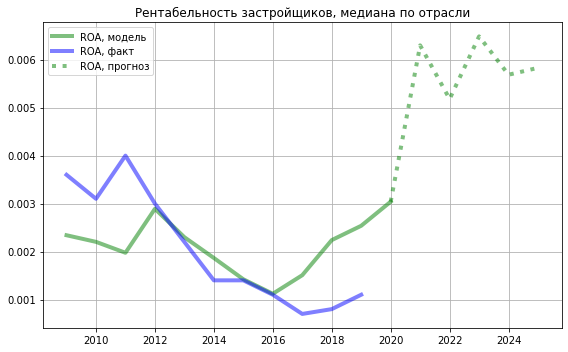

In [371]:
ax_roa=Ym_roa.plot.line(figsize=(8, 5), linewidth=4, alpha=0.5, grid=True,
         title='Рентабельность застройщиков, медиана по отрасли', color='g')
Y_roa.plot.line(ax=ax_roa, color='b', linewidth=4, alpha=0.5)
y_roa.plot.line(ax=ax_roa, color='g', style=':', linewidth=4, alpha=0.5, grid=True)
# pdfSubModResult.dropna().plot.line(ax=ax_roa, style='.-', color='maroon', linewidth=14, alpha=0.2)
plt.tight_layout()
plt.show();

### Модель *Чистая кредиторская задолженность (по модулю), медиана по отрасли (Z_A)*

**Предикторы:**  
  - Индекс физобъема выпуска (`I_phyvol_issue`, из данных Долгосрочной модели)
  - Изменение среднесписочной численности работников (`Chng_avrg_num_empls`, из данных Долгосрочной модели)
  
**Объясняемая переменная** - медианная по отрасли Чистая кредиторская задолженность(`Z_A` датафрейма `pdfSPARK`)

In [380]:
X_za, Y_za, x_za=prepare_fit_data(pdfSPARK[['year', 'Z_A']].copy(), 
                                  pdfXLS_model[['I_phyvol_issue', 'Chng_avrg_num_empls']].copy(), lag=1)

mdl_Z_A = sm.OLS(Y_za, X_za, missing='drop').fit()

resZ_A.summary()

/home/egor/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Z_A, факт   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     17.21
Date:                Tue, 28 Jul 2020   Prob (F-statistic):            0.00327
Time:                        16:46:22   Log-Likelihood:                 39.635
No. Observations:                   9   AIC:                            -73.27
Df Residuals:                       6   BIC:                            -72.68
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1516      0.065     -2.330      0.059      -0.311       0.008
I_phyvol_issue         -0.0887      0.039     -2.283      0.063      -0.184       0.006
Chng_avrg_num_empls     0.4391      0.075      5.839      0.001       0.255       0.623
==============================================================================
Omnibus:                        0.903   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.637   Jarque-Bera (JB):                0.720
Skew:                           0.526   Prob(JB):                        0.698
Kurtosis:                       2.098   Cond. No.                         138.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [373]:
Ym_za=pd.DataFrame(resZ_A.predict(), index=X_za.index, columns=['Z_A, модель'])
y_za=pd.DataFrame(resZ_A.predict(x_za), columns=['Z_A, прогноз'])[:-1]

# для графика - соединяем последнюю точку модели и первую прогноза
Ym_za.loc[y_za.index.tolist()[0]]=y_za.iloc[0].values 

# формируем датафрейм с данными для основной модели - модели банкротств
pdfSubModResult.loc[Y_za.index, 'Z_A_']=Y_za.iloc[:, 0]
pdfSubModResult.loc[y_za.index, 'Z_A_']=y_za.iloc[:, 0]
# pdfSubModResult

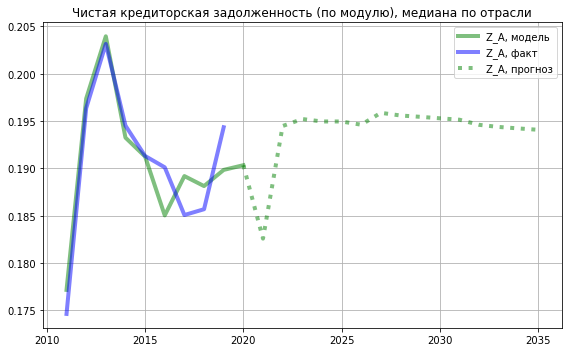

In [374]:
ax_za=Ym_za.plot.line(figsize=(8, 5), linewidth=4, alpha=0.5, grid=True,
         title='Чистая кредиторская задолженность (по модулю), медиана по отрасли', color='g')
Y_za.plot.line(ax=ax_za, color='b', linewidth=4, alpha=0.5)
y_za.plot.line(ax=ax_za, color='g', style=':', linewidth=4, alpha=0.5, grid=True)

# pdfSubModResult['Z_A_'].dropna().plot.line(ax=ax_za, color='grey', linewidth=14, alpha=0.3)

plt.tight_layout()
plt.show();

### Модель *Ставка по кредитам*


<AxesSubplot:xlabel='date'>

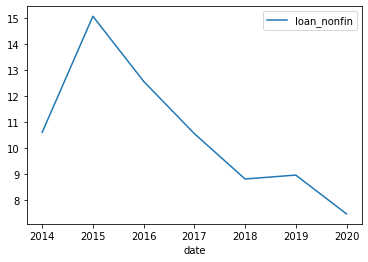

In [404]:
pdf=pdfLOAN.set_index('date').groupby(by=pd.Grouper(freq='Y')).agg(np.median)
pdf.index=pdf.index.year
pdf.plot.line()

## Оценка и расчет основной модели "Банкротства застройщиков"

Данные - в `pdfSubModResult`

In [413]:
# pdfSubModResult.dropna()
# pdfNoza.sort_values('completion_year').join(pdfSPARK, on='inn')
pdfNoza

,inn,completion_year,price,square
0,0105003792,2020,367349984,9327.82
1,0105008695,2020,284736960,6943.00
2,0106003795,2020,249000000,9639.37
3,0107008891,2020,98972928,4680.96
4,0107022575,2020,582293936,18055.21
...,...,...,...,...
4611,9721014302,2022,3670516032,86832.00
4612,9729020072,2021,830013248,4973.35
4613,9729055420,2020,12000000000,103241.10
4614,9731000154,2021,2738303104,41658.12


In [397]:
import patsy
import statsmodels.formula.api as smf

# resROA = sm.OLS(Y_roa, X_roa, missing='drop').fit()

# resROA.summary()

pdf=pdfXLS_model[['I_nom_prices_sec_market', 'marga']].copy()
pdf['ROA']=Y_roa

resROA_f = smf.ols(formula='ROA ~ I_nom_prices_sec_market + marga', missing='drop', data=pdf).fit()

resROA_f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROA   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.9513
Date:                Tue, 28 Jul 2020   Prob (F-statistic):              0.426
Time:                        17:16:55   Log-Likelihood:                 60.121
No. Observations:                  11   AIC:                            -114.2
Df Residuals:                       8   BIC:                            -113.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.0122      0.010     -1.182      0.271      -0.036       0.012
I_nom_prices_sec_market     0.0080      0.007      1.211      0.261      -0.007       0.023
marga                       0.0049      0.004      1.106      0.301      -0.005       0.015
==============================================================================
Omnibus:                        0.481   Durbin-Watson:                   0.561
Prob(Omnibus):                  0.786   Jarque-Bera (JB):                0.424
Skew:                           0.377   Prob(JB):                        0.809
Kurtosis:                       2.404   Cond. No.                         65.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [398]:
resROA_f.predict()

array([0.00234028, 0.00220217, 0.00197468, 0.002891  , 0.00229909,
       0.00186619, 0.00142219, 0.00112016, 0.00150752, 0.00223908,
       0.00253764])

In [120]:
# pdfSPARK=pdfSPARK.loc[pdfSPARK[['capital', 'Cancel_date', 'ROA', 'Z_A']].dropna(how='all').index, :]
# pdfM=pdfSPARK.merge(pdfNoza, on='inn')
# pdfM.loc[pdfM['inn']=='5050102110']

In [121]:
# pdfSPARK.loc[pdfSPARK['inn']=='6232001460']

In [122]:
# pdfT=pd.read_sql('select * from spark', con=conWork)
# pdfT.loc[(pdfT['inn']=='6232001460')]

In [15]:

# res.loc[idx[2015:2019, :], idx[:]]

<div class="alert alert-block alert-info">
<b>Для изменения данных в ручном режиме использовать шаблон</b>

</div>

```python
pdfXLS_model.loc[2010, 'I_nom_prices_sec_market'] = 0
```

pdfXLS_model.loc[<год>, <название нужной колонки или список колонок>] = <нужное значение или список значений>

In [263]:
pdf['const']=1.0
model_indep = sm.GEE.from_formula(
    "rent_otr ~ marga + i_price",
    cov_struct = sm.cov_struct.Independence(),
    groups = 'const',
    data=pdf.reset_index()
    ).fit()
model_indep.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                    rent_otr   No. Observations:                   11
Model:                                 GEE   No. clusters:                        1
Method:                        Generalized   Min. cluster size:                  11
                      Estimating Equations   Max. cluster size:                  11
Family:                           Gaussian   Mean cluster size:                11.0
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Fri, 24 Jul 2020   Scale:                           0.000
Covariance type:                    robust   Time:                         17:04:15
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0122    7.4e-17  -1.65e+14      0.000      -0.012      -0.012
marga          0.0049   2.52e-17   1.95e+14      0.000       0.005       0.005
i_price        0.0080   4.31e-17   1.85e+14      0.000       0.008       0.008
==============================================================================
Skew:                          0.3773   Kurtosis:                      -0.5960
Centered skew:                 0.3773   Centered kurtosis:             -0.5960
==============================================================================
"""

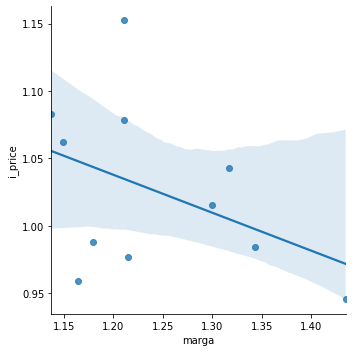

In [143]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Store the url string that hosts our .csv file
# url = "Cartwheeldata.csv"

# Read the .csv file and store it as a pandas Data Frame
# df = pd.read_csv(url)

# Create Scatterplot
sns.lmplot(x='marga', y='i_price', data=pdf)

plt.show()

In [ ]:
# Scatterplot arguments
# sns.lmplot(x='Wingspan', y='CWDistance', data=df,
#            fit_reg=False, # No regression line
#            hue='Gender')   # Color by evolution stage

# plt.show()